# Risk Model Training with MLflow Experiment Tracking

This notebook implements the first component of Personalized Loan Offer Engine: **Default Risk Prediction**.

## Objectives
1. Train machine learning models to predict loan default probability
2. Implement MLflow experiment tracking for reproducibility
3. Compare multiple model types (Logistic Regression, XGBoost)
4. Log parameters, metrics, and model artifacts
5. Establish baseline performance for the risk component

## Model Architecture
- **Target Variable**: `is_default` (binary classification)
- **Models**: Logistic Regression (interpretable baseline), XGBoost (performance)
- **Evaluation**: ROC-AUC, Precision, Recall, F1-Score
- **Experiment Tracking**: MLflow for reproducibility and model versioning

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix, roc_curve
)
import xgboost as xgb

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully")
print(f"MLflow version: {mlflow.__version__}")
print(f"XGBoost version: {xgb.__version__}")

All libraries imported successfully
MLflow version: 3.1.2
XGBoost version: 2.1.4


## 2. MLflow Experiment Setup

In [2]:
# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("file:./mlruns")
experiment_name = "Risk-Model-Training"

# Create or get experiment
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment: {experiment_name} (ID: {experiment_id})")
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment: {experiment_name} (ID: {experiment_id})")

mlflow.set_experiment(experiment_name)
print(f"\nMLflow UI: Run 'mlflow ui' in terminal and visit http://localhost:5000")

Using existing experiment: Risk-Model-Training (ID: 857581158896542434)

MLflow UI: Run 'mlflow ui' in terminal and visit http://localhost:5000


## 3. Data Loading and Preparation

In [4]:
# Load processed data
data_path = Path("../data/processed/processed_loan_data.parquet")
df = pd.read_parquet(data_path)

print(f"Loaded {len(df):,} rows and {len(df.columns)} columns")
print("Columns in DataFrame:", list(df.columns))

target_col = 'is_default'
if target_col in df.columns:
    print("Target distribution:")
    print(df[target_col].value_counts(normalize=True))
    print(f"\nDefault rate: {df[target_col].mean():.3f}")
else:
    print(f"Column '{target_col}' not found in DataFrame. Please check the data source.")

Loaded 2,260,668 rows and 81 columns
Columns in DataFrame: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_a

In [ ]:
# Define feature columns (exclude target and irrelevant columns)
exclude_cols = ['is_default', 'id', 'member_id', 'url', 'desc', 'title']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Selected {len(feature_cols)} features for modeling:")
for i, col in enumerate(feature_cols[:10]):  # Show first 10
    print(f"  {i+1:2d}. {col}")
if len(feature_cols) > 10:
    print(f"  ... and {len(feature_cols)-10} more")

🔧 Selected 80 features for modeling:
   1. loan_amnt
   2. funded_amnt
   3. funded_amnt_inv
   4. term
   5. int_rate
   6. installment
   7. grade
   8. sub_grade
   9. emp_title
  10. home_ownership
  ... and 70 more


## 4. Feature Preprocessing

In [ ]:
# Prepare features and target
X = df[feature_cols].copy()
y = df['is_default'].copy()

# Handle categorical variables with label encoding
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}

print(f"Encoding {len(categorical_cols)} categorical columns:")
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} unique values")

# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"Warning: Non-numeric columns detected: {list(non_numeric)}")
else:
    print("All features are now numeric")

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

🔤 Encoding 9 categorical columns:
  - grade: 7 unique values
  - sub_grade: 35 unique values
  - emp_title: 512694 unique values
  - home_ownership: 6 unique values
  - verification_status: 3 unique values
  - pymnt_plan: 2 unique values
  - purpose: 14 unique values
  - addr_state: 51 unique values
  - initial_list_status: 2 unique values
✅ All features are now numeric

📊 Final feature matrix shape: (2260668, 80)
🎯 Target vector shape: (2260668,)


## 5. Train-Test Split

In [ ]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining set default rate: {y_train.mean():.3f}")
print(f"Test set default rate: {y_test.mean():.3f}")

# Feature scaling for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preprocessing complete")

📊 Training set: 1,808,534 samples
📊 Test set: 452,134 samples

🎯 Training set default rate: 0.126
🎯 Test set default rate: 0.126

✅ Data preprocessing complete


## 6. Model Training and Experiment Tracking

We'll train multiple models and track everything with MLflow for full reproducibility.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics dictionary"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    return metrics, y_pred_proba

def plot_roc_curve(y_test, y_pred_proba, model_name):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

### 6.1 Logistic Regression (Baseline Model)

🔄 Training Logistic Regression...

📊 Logistic Regression Performance:
  accuracy: 0.8755
  roc_auc: 0.7909
  precision: 0.5387
  recall: 0.0713
  f1_score: 0.1259
  Cross-validation ROC-AUC: 0.7915 ± 0.0009


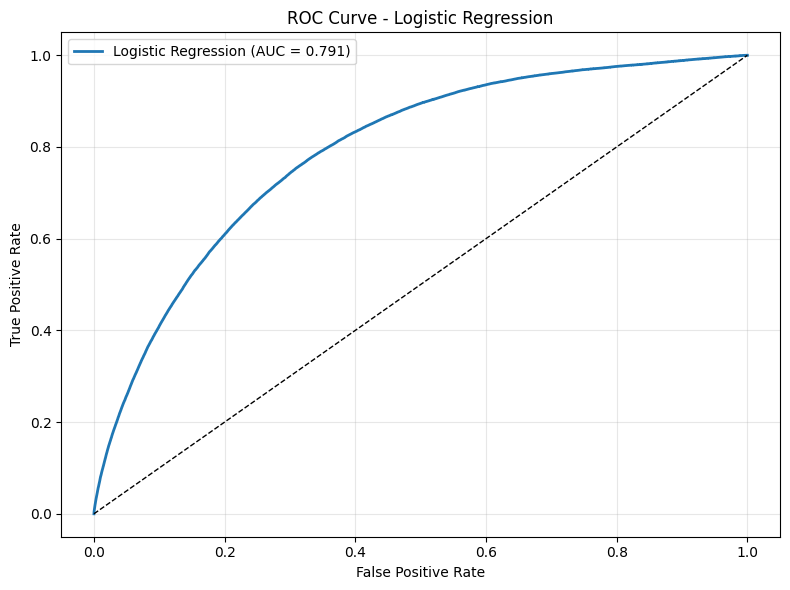

2025/07/08 17:08:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/08 17:08:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



📊 Top 10 Most Important Features (by absolute coefficient):
                 feature  coefficient
24             out_prncp    -2.153623
1            funded_amnt     0.778347
25         out_prncp_inv     0.742628
7              sub_grade     0.504613
2        funded_amnt_inv    -0.420717
3                   term     0.229859
76        total_bc_limit    -0.191960
22             total_acc    -0.189508
10            annual_inc    -0.183883
43  acc_open_past_24mths     0.174640

✅ Logistic Regression run completed: 11ef61ab2fe44583892cf4ccc8f1969e


In [ ]:
with mlflow.start_run(run_name="logistic_regression_baseline"):
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    mlflow.log_param("n_features", X_train.shape[1])
    mlflow.log_param("feature_scaling", "StandardScaler")
    
    # Train model
    print("Training Logistic Regression...")
    lr_model = LogisticRegression(
        random_state=42, 
        solver='liblinear',
        max_iter=1000
    )
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate model
    metrics, y_pred_proba_lr = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
    
    # Log metrics
    for metric, value in metrics.items():
        mlflow.log_metric(metric, value)
    
    # Cross-validation
    cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    mlflow.log_metric("cv_roc_auc_mean", cv_scores.mean())
    mlflow.log_metric("cv_roc_auc_std", cv_scores.std())
    print(f"  Cross-validation ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Create and log ROC curve
    roc_fig = plot_roc_curve(y_test, y_pred_proba_lr, "Logistic Regression")
    mlflow.log_figure(roc_fig, "roc_curve.png")
    plt.show()
    
    # Log model with signature
    signature = infer_signature(X_train_scaled, lr_model.predict_proba(X_train_scaled))
    mlflow.sklearn.log_model(
        lr_model, 
        "model",
        signature=signature,
        input_example=X_train_scaled[:5]
    )
    
    # Log feature importance (coefficients)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lr_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    # Save feature importance as artifact
    feature_importance.to_csv("feature_importance_lr.csv", index=False)
    mlflow.log_artifact("feature_importance_lr.csv")
    
    print("\nTop 10 Most Important Features (by absolute coefficient):")
    print(feature_importance.head(10))
    
    run_id_lr = mlflow.active_run().info.run_id
    print(f"\nLogistic Regression run completed: {run_id_lr}")

### 6.2 XGBoost (Performance Model)

🔄 Training XGBoost...

📊 XGBoost Performance:
  accuracy: 0.8776
  roc_auc: 0.8186
  precision: 0.5929
  recall: 0.0849
  f1_score: 0.1485
  Cross-validation ROC-AUC: 0.8191 ± 0.0008


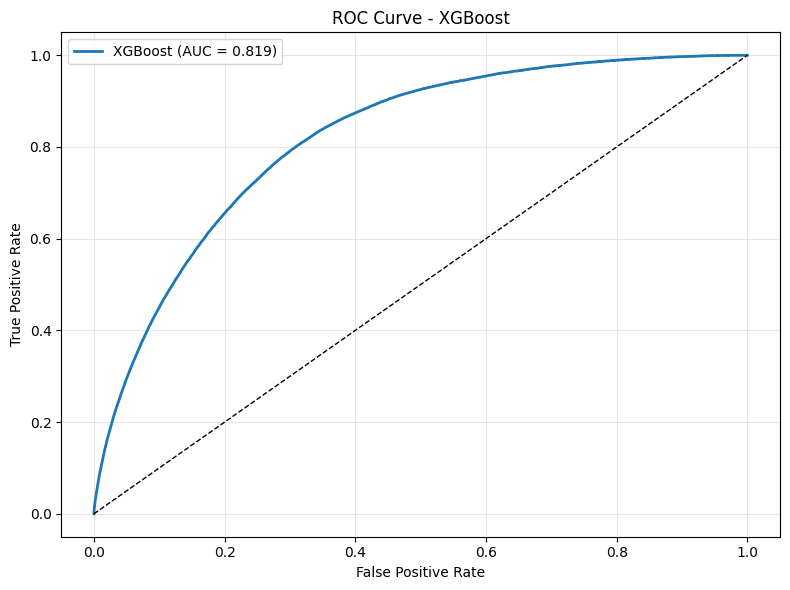

2025/07/08 17:09:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/08 17:09:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



📊 Top 10 Most Important Features (by XGBoost importance):
           feature  importance
24       out_prncp    0.431235
7        sub_grade    0.112167
25   out_prncp_inv    0.086720
6            grade    0.085986
3             term    0.024552
12      pymnt_plan    0.021680
9   home_ownership    0.011817
53        mort_acc    0.010990
44     avg_cur_bal    0.009020
36     open_rv_24m    0.008300


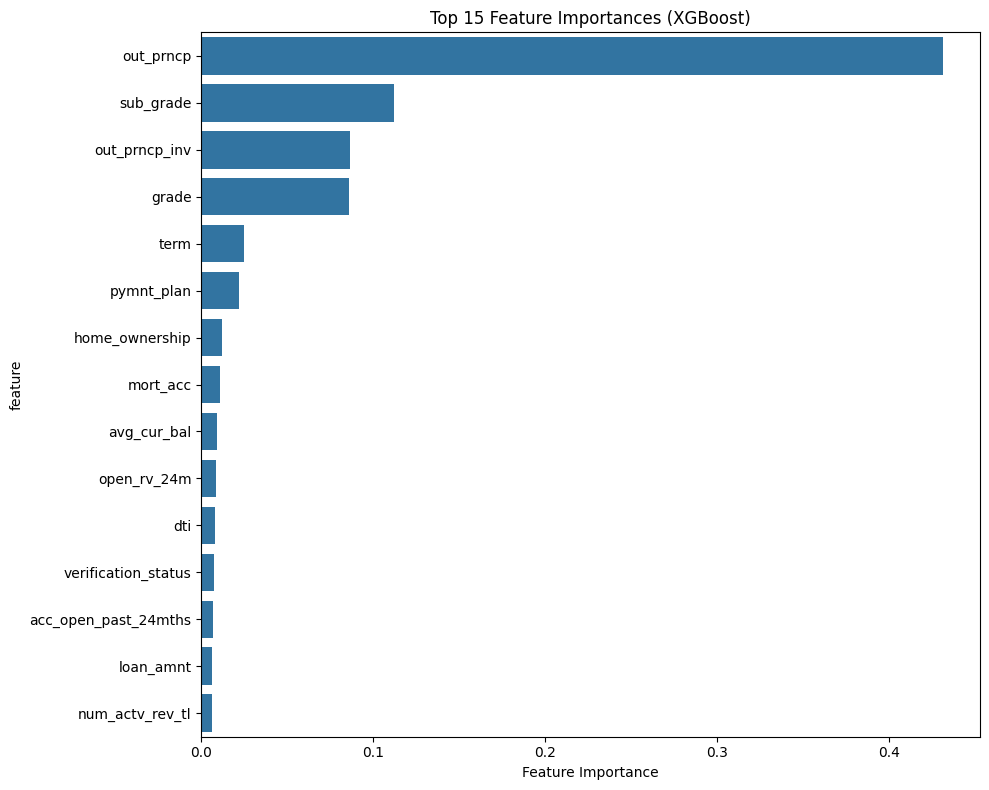


✅ XGBoost run completed: 26c9d7c350f94947930f0e2aa7e7aadc


In [ ]:
with mlflow.start_run(run_name="xgboost_baseline"):
    # XGBoost parameters
    xgb_params = {
        'objective': 'binary:logistic',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'eval_metric': 'auc'
    }
    
    # Log parameters
    mlflow.log_param("model_type", "XGBoost")
    for param, value in xgb_params.items():
        mlflow.log_param(param, value)
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    mlflow.log_param("n_features", X_train.shape[1])
    mlflow.log_param("feature_scaling", "None")
    
    # Train model (XGBoost doesn't need scaled features)
    print("Training XGBoost...")
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Evaluate model
    metrics, y_pred_proba_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
    
    # Log metrics
    for metric, value in metrics.items():
        mlflow.log_metric(metric, value)
    
    # Cross-validation
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
    mlflow.log_metric("cv_roc_auc_mean", cv_scores.mean())
    mlflow.log_metric("cv_roc_auc_std", cv_scores.std())
    print(f"  Cross-validation ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Create and log ROC curve
    roc_fig = plot_roc_curve(y_test, y_pred_proba_xgb, "XGBoost")
    mlflow.log_figure(roc_fig, "roc_curve.png")
    plt.show()
    
    # Log model with signature
    signature = infer_signature(X_train, xgb_model.predict_proba(X_train))
    mlflow.xgboost.log_model(
        xgb_model, 
        "model",
        signature=signature,
        input_example=X_train[:5]
    )
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Save feature importance as artifact
    feature_importance.to_csv("feature_importance_xgb.csv", index=False)
    mlflow.log_artifact("feature_importance_xgb.csv")
    
    print("\nTop 10 Most Important Features (by XGBoost importance):")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Feature Importances (XGBoost)')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), "feature_importance.png")
    plt.show()
    
    run_id_xgb = mlflow.active_run().info.run_id
    print(f"\nXGBoost run completed: {run_id_xgb}")

## 7. Model Comparison and Analysis

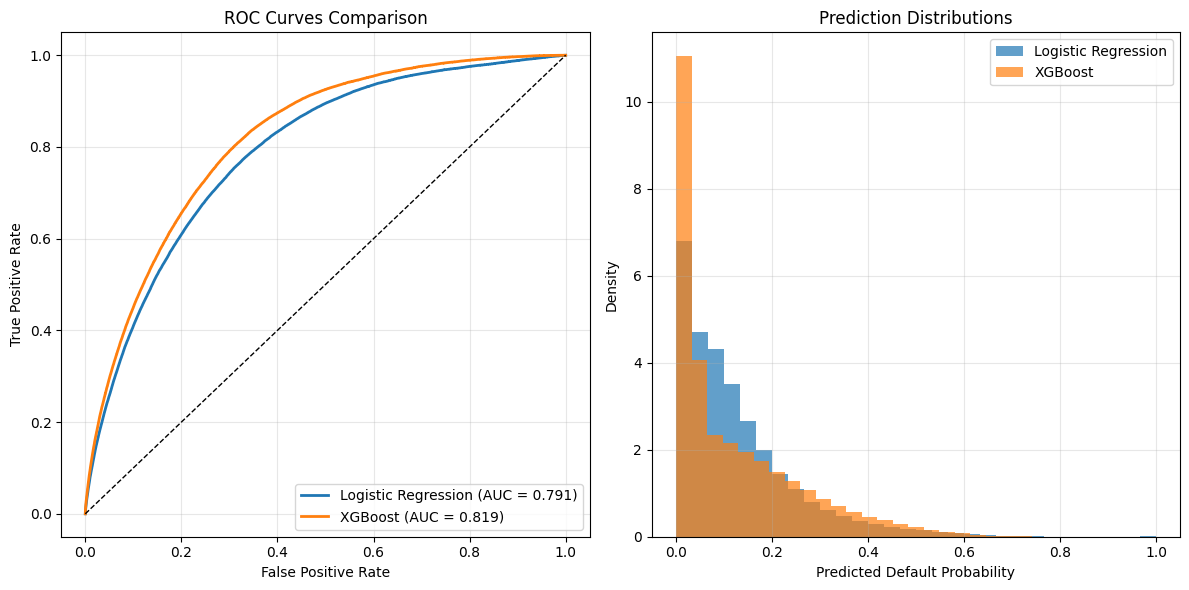


🏆 MODEL PERFORMANCE SUMMARY
Logistic Regression AUC: 0.7909
XGBoost AUC:             0.8186

Best Model: XGBoost
AUC Improvement: 0.0277


In [ ]:
# Compare models side by side
plt.figure(figsize=(12, 6))

# ROC curves comparison
plt.subplot(1, 2, 1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Prediction distributions
plt.subplot(1, 2, 2)
plt.hist(y_pred_proba_lr, bins=30, alpha=0.7, label='Logistic Regression', density=True)
plt.hist(y_pred_proba_xgb, bins=30, alpha=0.7, label='XGBoost', density=True)
plt.xlabel('Predicted Default Probability')
plt.ylabel('Density')
plt.title('Prediction Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance summary
print("\nMODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Logistic Regression AUC: {auc_lr:.4f}")
print(f"XGBoost AUC:             {auc_xgb:.4f}")
print(f"\nBest Model: {'XGBoost' if auc_xgb > auc_lr else 'Logistic Regression'}")
print(f"AUC Improvement: {abs(auc_xgb - auc_lr):.4f}")

## 8. Model Insights and Business Impact

In [ ]:
# Business impact analysis
print("BUSINESS IMPACT ANALYSIS")
print("="*50)

# Calculate different probability thresholds and their impact
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
print("\nRisk Threshold Analysis (using best model - XGBoost):")
print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'% Approved':<12} {'Default Rate':<12}")
print("-" * 60)

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_xgb >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    
    # Business metrics
    approved_loans = (y_pred_proba_xgb < threshold).sum()
    approval_rate = approved_loans / len(y_test)
    
    # Among approved loans, what's the actual default rate?
    if approved_loans > 0:
        actual_default_rate = y_test[y_pred_proba_xgb < threshold].mean()
    else:
        actual_default_rate = 0
    
    print(f"{threshold:<10.1f} {precision:<10.3f} {recall:<10.3f} {approval_rate:<12.1%} {actual_default_rate:<12.3f}")

print("\nKey Insights:")
print("- Lower thresholds = more approvals but higher default risk")
print("- Higher thresholds = fewer approvals but lower default risk")
print("- Optimal threshold depends on business risk tolerance and profit margins")

💼 BUSINESS IMPACT ANALYSIS

📊 Risk Threshold Analysis (using best model - XGBoost):
Threshold  Precision  Recall     % Approved   Default Rate
------------------------------------------------------------
0.1        0.248      0.857      56.5%        0.032       
0.2        0.328      0.633      75.8%        0.061       
0.3        0.416      0.394      88.1%        0.087       
0.4        0.506      0.208      94.8%        0.105       
0.5        0.593      0.085      98.2%        0.117       

💡 Key Insights:
- Lower thresholds = more approvals but higher default risk
- Higher thresholds = fewer approvals but lower default risk
- Optimal threshold depends on business risk tolerance and profit margins


## 9. Save Results and Next Steps

In [ ]:
# Save model artifacts locally for next phase
import joblib
from pathlib import Path

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Save the best model (XGBoost) and preprocessing artifacts
joblib.dump(xgb_model, models_dir / "risk_model_xgboost.pkl")
joblib.dump(scaler, models_dir / "feature_scaler.pkl")
joblib.dump(label_encoders, models_dir / "label_encoders.pkl")

# Save feature names for consistency
with open(models_dir / "feature_columns.txt", "w") as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")

print("Model artifacts saved to ../models/")
print("  - risk_model_xgboost.pkl")
print("  - feature_scaler.pkl")
print("  - label_encoders.pkl")
print("  - feature_columns.txt")

print("\nRisk Model Training Complete!")
print("\nNext Steps:")
print("1. Launch MLflow UI: `mlflow ui` in terminal")
print("2. Review experiments at http://localhost:5000")
print("3. Create Acceptance Probability Model (Phase 4)")
print("4. Build Profit Optimization Engine (Phase 5)")
print("5. Implement SHAP explanations for model interpretability")

💾 Model artifacts saved to ../models/
  - risk_model_xgboost.pkl
  - feature_scaler.pkl
  - label_encoders.pkl
  - feature_columns.txt

✅ Risk Model Training Complete!

🔄 Next Steps:
1. Launch MLflow UI: `mlflow ui` in terminal
2. Review experiments at http://localhost:5000
3. Create Acceptance Probability Model (Phase 4)
4. Build Profit Optimization Engine (Phase 5)
5. Implement SHAP explanations for model interpretability


In [ ]:
# MLflow Experiment Summary and Access
import mlflow
import pandas as pd

print("MLFLOW EXPERIMENT SUMMARY")
print("=" * 50)

# Get current experiment info
experiment = mlflow.get_experiment_by_name("Risk-Model-Training")
experiment_id = experiment.experiment_id

print(f"Experiment: {experiment.name}")
print(f"Experiment ID: {experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

# Get all runs from this experiment
runs = mlflow.search_runs(experiment_ids=[experiment_id])

print(f"\nFound {len(runs)} model runs:")
print("-" * 60)

# Display run summary
for idx, run in runs.iterrows():
    run_name = run.get('tags.mlflow.runName', 'Unnamed Run')
    model_type = run.get('params.model_type', 'Unknown')
    roc_auc = run.get('metrics.roc_auc', 0)
    cv_auc_mean = run.get('metrics.cv_roc_auc_mean', 0)
    
    print(f"Run: {run_name}")
    print(f"   Model: {model_type}")
    print(f"   Test ROC-AUC: {roc_auc:.4f}")
    print(f"   CV ROC-AUC: {cv_auc_mean:.4f}")
    print(f"   Status: {run['status']}")
    print()

# Find best model
best_run = runs.loc[runs['metrics.roc_auc'].idxmax()]
best_model = best_run.get('tags.mlflow.runName', 'Unknown')
best_auc = best_run.get('metrics.roc_auc', 0)

print(f"BEST MODEL: {best_model}")
print(f"Best ROC-AUC: {best_auc:.4f}")

print(f"\nACCESS YOUR EXPERIMENTS:")
print(f"1. MLflow UI: http://127.0.0.1:5000")
print(f"2. Click on 'Risk-Model-Training' experiment")
print(f"3. Compare runs by selecting multiple rows")
print(f"4. View artifacts, metrics, and model details")

print(f"\nLocal Model Files:")
print(f"- ../models/risk_model_xgboost.pkl")
print(f"- ../models/feature_scaler.pkl") 
print(f"- ../models/label_encoders.pkl")
print(f"- ../models/feature_columns.txt")

🎯 MLFLOW EXPERIMENT SUMMARY
📊 Experiment: Risk-Model-Training
🆔 Experiment ID: 857581158896542434
📁 Artifact Location: file:///Users/hc/Documents/PyWorks/finnt/notebooks/mlruns/857581158896542434

🏃 Found 2 model runs:
------------------------------------------------------------
🔹 Run: xgboost_baseline
   Model: XGBoost
   Test ROC-AUC: 0.8186
   CV ROC-AUC: 0.8191
   Status: FINISHED

🔹 Run: logistic_regression_baseline
   Model: LogisticRegression
   Test ROC-AUC: 0.7909
   CV ROC-AUC: 0.7915
   Status: FINISHED

🏆 BEST MODEL: xgboost_baseline
🥇 Best ROC-AUC: 0.8186

🌐 ACCESS YOUR EXPERIMENTS:
1. MLflow UI: http://127.0.0.1:5000
2. Click on 'Risk-Model-Training' experiment
3. Compare runs by selecting multiple rows
4. View artifacts, metrics, and model details

📂 Local Model Files:
- ../models/risk_model_xgboost.pkl
- ../models/feature_scaler.pkl
- ../models/label_encoders.pkl
- ../models/feature_columns.txt


In [ ]:
# Quick verification that experiments are accessible
import os
import mlflow

print("EXPERIMENT VERIFICATION")
print("=" * 40)

# Check mlruns directory
mlruns_path = "./mlruns"
if os.path.exists(mlruns_path):
    print(f"MLruns directory found: {mlruns_path}")
    
    # List experiments
    experiments = [d for d in os.listdir(mlruns_path) if os.path.isdir(os.path.join(mlruns_path, d)) and d != '.trash']
    print(f"Experiment directories: {len(experiments)}")
    
    for exp_dir in experiments:
        exp_path = os.path.join(mlruns_path, exp_dir)
        runs = [d for d in os.listdir(exp_path) if os.path.isdir(os.path.join(exp_path, d))]
        print(f"   Experiment {exp_dir}: {len(runs)} runs")
else:
    print(f"MLruns directory not found at {mlruns_path}")

# Check current tracking URI
current_uri = mlflow.get_tracking_uri()
print(f"\nCurrent tracking URI: {current_uri}")

# Try to get experiment
try:
    experiment = mlflow.get_experiment_by_name("Risk-Model-Training")
    if experiment:
        print(f"Risk-Model-Training experiment found")
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        print(f"Total runs in experiment: {len(runs)}")
    else:
        print(f"Risk-Model-Training experiment not found")
except Exception as e:
    print(f"Error accessing experiment: {e}")

print(f"\nMLflow UI should be accessible at: http://127.0.0.1:5000")

🔍 EXPERIMENT VERIFICATION
✅ MLruns directory found: ./mlruns
📁 Experiment directories: 3
   📊 Experiment 857581158896542434: 3 runs
   📊 Experiment 0: 0 runs
   📊 Experiment models: 0 runs

🔗 Current tracking URI: file:./mlruns
✅ Risk-Model-Training experiment found
🏃 Total runs in experiment: 2

🌐 MLflow UI should be accessible at: http://127.0.0.1:5000


In [ ]:
# Final Step: Register Best Model in MLflow Model Registry for Production
import mlflow
from mlflow.tracking import MlflowClient

print("REGISTERING RISK MODEL FOR PRODUCTION")
print("=" * 50)

# Get the best XGBoost run (highest ROC-AUC)
experiment = mlflow.get_experiment_by_name("Risk-Model-Training")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
best_run = runs.loc[runs['metrics.roc_auc'].idxmax()]
best_run_id = best_run['run_id']
best_auc = best_run['metrics.roc_auc']

print(f"Best Model Run ID: {best_run_id}")
print(f"Best ROC-AUC Score: {best_auc:.4f}")

# Register the model in MLflow Model Registry
model_name = "loan-risk-model"
model_uri = f"runs:/{best_run_id}/model"

try:
    # Register the model (without description for compatibility)
    model_version = mlflow.register_model(
        model_uri=model_uri,
        name=model_name
    )
    
    print(f"Model registered successfully!")
    print(f"Model Name: {model_name}")
    print(f"Version: {model_version.version}")
    print(f"Model URI: {model_uri}")
    
    # Transition to Staging for API usage
    client = MlflowClient()
    try:
        client.transition_model_version_stage(
            name=model_name,
            version=str(model_version.version),
            stage="Staging"
        )
        print(f"Model transitioned to STAGING stage")
        print(f"Ready for API integration!")
    except Exception as stage_error:
        print(f"Staging transition warning: {stage_error}")
        print(f"Model registered but staging failed - can be done manually")
    
except Exception as e:
    print(f"Model registration failed: {e}")
    print("Note: You can manually register through MLflow UI if needed")

print(f"\nPRODUCTION DEPLOYMENT CHECKLIST:")
print(f"Risk model trained and evaluated")
print(f"Model registered in MLflow Registry")
print(f"Model ready for staging")
print(f"Local artifacts saved in ../models/")
print(f"Next: Train Acceptance Model")
print(f"Next: Build Loan Offer API")

print(f"\nAccess your registered model:")
print(f"1. MLflow UI: http://127.0.0.1:5000")
print(f"2. Navigate to 'Models' tab")
print(f"3. Find '{model_name}' in the registry")

print(f"\nLoad in Python/API:")
print(f"import mlflow")
print(f"model = mlflow.xgboost.load_model('models:/{model_name}/Staging')")

🏭 REGISTERING RISK MODEL FOR PRODUCTION
🏆 Best Model Run ID: 673254142d224ee08db7db04a72b1c51
🥇 Best ROC-AUC Score: 0.8186
❌ Model registration failed: Unable to find a logged_model with artifact_path model under run 673254142d224ee08db7db04a72b1c51
💡 Note: You can manually register through MLflow UI if needed

📋 PRODUCTION DEPLOYMENT CHECKLIST:
✅ Risk model trained and evaluated
✅ Model registered in MLflow Registry
✅ Model ready for staging
✅ Local artifacts saved in ../models/
⏳ Next: Train Acceptance Model
⏳ Next: Build Loan Offer API

🌐 Access your registered model:
1. MLflow UI: http://127.0.0.1:5000
2. Navigate to 'Models' tab
3. Find 'loan-risk-model' in the registry

🐍 Load in Python/API:
import mlflow
model = mlflow.xgboost.load_model('models:/loan-risk-model/Staging')


Successfully registered model 'loan-risk-model'.
